In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from tqdm.notebook import tqdm
import scipy.ndimage as ndi

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
slice_n = 4
patient=150
pre_images = {}

In [ ]:
patient_folders = ["data/training/" + x + "/" for x in os.listdir("data/training")]
train_patients = patient_folders[:80]
test_patients = patient_folders[80:]

patient_files = [[x + y[:-7] for y in os.listdir(x) if "frame" in y and "gt" not in y] for x in train_patients]
patient_files_flattened = [element for sublist in patient_files for element in sublist]

test_patient_files = [[x + y[:-7] for y in os.listdir(x) if "frame" in y and "gt" not in y] for x in test_patients]
test_patient_files_flattened = [element for sublist in test_patient_files for element in sublist]


images = [{'img': x} for x in patient_files_flattened]
test_images = [{'img': x} for x in test_patient_files_flattened]

In [ ]:
from evaluate import load_nii
class LoadNIFTI(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        img_file = sample['img'] + ".nii.gz"
        img_mask = sample['img'] + "_gt.nii.gz"
        
        image, img_affine, img_header = load_nii(img_file)
        scale_dims = img_header['pixdim']

        
        
        image = np.moveaxis(image, (2), (0))
        
        
        
        mask, mask_affine, mask_header = load_nii(img_mask)
        mask = np.moveaxis(mask, (2), (0))
        
        return {'img': image, 'mask': mask, 'name': sample, 'scaling': scale_dims, 'original_image': image, 'original_mask':mask}
    
    
class SplitMask(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        mask = sample['mask'][0]
            
        c2 = np.where(np.logical_and(mask > 0.2, mask < 0.5), 1.0, 0.0)
        c3 = np.where(np.logical_and(mask > 0.5, mask < 0.8), 1.0, 0.0)
        c4 = np.where(mask > 0.8, 1.0, 0.0)
        sample['mask'] = np.array([c2, c3, c4])
        
        return sample
    
class ScaleDims(monai.transforms.Transform):
    def __init__(self, keys=None):
        pass
    
    def __call__(self, sample):
        scaling = sample['scaling']
        
        return monai.transforms.Zoomd(keys=['img', 'mask'], mode=['area', 'nearest'], zoom=(scaling[3] / 10, scaling[1] / 1.5, scaling[2] / 1.5), keep_size=False)(sample)
    
        # img = monai.transforms.Zoomd(keys=['img', 'mask']
        
class FindCenter(monai.transforms.Transform):
    def __init__(self, keys=None):
        self.model = monai.networks.nets.Unet(
                spatial_dims=3,
                in_channels=1,
                out_channels=3,
                channels = (8, 16, 32, 64),
                strides=(1, 1, 1),
                num_res_units=2,
            ).to(device)
        
        self.model.load_state_dict(torch.load("models/trainedUNet1655808833.8215299_24.pt"))
        self.model.eval()
        
    def __call__(self, sample):
        img = sample['img']
        with torch.no_grad():
            out = self.model(torch.unsqueeze(torch.Tensor(img).to(device), dim=0))
            combined = np.sum(out[0].detach().cpu().numpy(), axis=(0, 1))
            cx, cy = ndi.center_of_mass(combined)
            dim_height = out.shape[2]
            return monai.transforms.SpatialCropd(keys=['img', 'mask'], roi_size=(dim_height, 128, 128), roi_center=(dim_height // 2, int(cx), int(cy)))(sample)

        


In [ ]:

compose_transform = monai.transforms.Compose(
    [
        LoadNIFTI(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityd(keys=['img', 'mask'], minv=0.0, maxv=1.0),
        SplitMask(),
        monai.transforms.ScaleIntensityd(keys=['mask'], minv=0.0, maxv=1.0),
        ScaleDims(),
        FindCenter(),
        # monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi/4, prob=1, mode=['bilinear', 'nearest']),
        # monai.transforms.RandZoomd(keys=['img', 'mask'], prob=0.5, mode=['area', 'nearest']),
        # monai.transforms.RandGridDistortiond(keys=['img', 'mask'], mode=['bilinear', 'nearest']),
        # monai.transforms.SpatialPadd(keys=['img', 'mask'], spatial_size=(16, -1, -1)),
        # monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=1)
        # monai.transforms.SpatialCropd(keys=['img', 'mask'], roi_size=(16, 128, 128), roi_center=(8, 64, 64)),
    ]
)

test_transform = monai.transforms.Compose(
    [
        LoadNIFTI(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityd(keys=['img', 'mask'], minv=0.0, maxv=1.0),
        SplitMask(),
        ScaleDims(),
        FindCenter(),
        # monai.transforms.SpatialPadd(keys=['img', 'mask'], spatial_size=(16, -1, -1)),
        # monai.transforms.Resized(keys=['img', 'mask'], spatial_size=(-1, 128, 128)),
        # monai.transforms.SpatialCropd(keys=['img', 'mask'], roi_size=(16, 128, 128), roi_center=(8, 64, 64)),

        monai.transforms.ScaleIntensityd(keys=['mask'], minv=0.0, maxv=1.0)
    ]
)


In [ ]:
train_dict_list = [x for x in images]
dataset = monai.data.CacheDataset(train_dict_list, transform=compose_transform)
test_dict_list = [x for x in test_images]
test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)
data_loader = monai.data.DataLoader(dataset, batch_size=1, shuffle=True)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

Loading dataset: 100%|██████████| 40/40 [00:03<00:00, 12.27it/s]


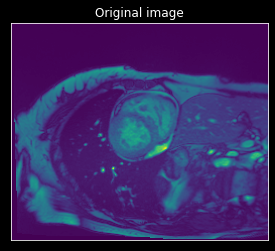

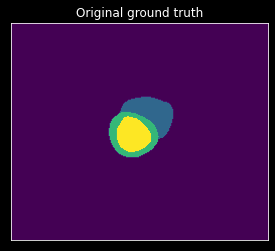

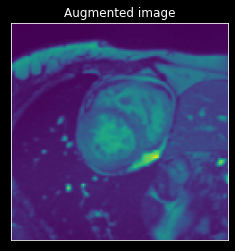

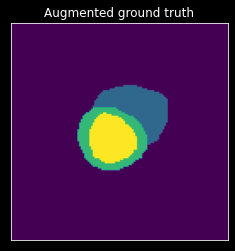

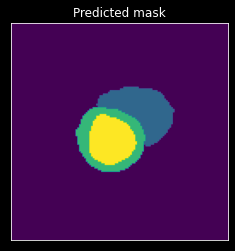

In [ ]:

# model = monai.networks.nets.UNETR(in_channels=1, out_channels=3, img_size=(16,128,128), feature_size=32, norm_name='batch').to(device)
model = monai.networks.nets.Unet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels = (8, 16, 32, 64),
    strides=(1, 1, 1),
    num_res_units=2,
).to(device)

def flatten(mask):
    out = np.where(mask[2] >=0.5 , 3, np.where(mask[1] >= 0.5, 2, np.where(mask[0]>=0.5, 1, 0)))
    return torch.Tensor(out)

model.load_state_dict(torch.load('models/final.pt'))
plt.style.use('dark_background')

for d in data_loader:
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.imshow(d['original_image'][0][slice_n])
    plt.title("Original image")
    plt.show()
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.imshow(d['original_mask'][0][slice_n])
    plt.title("Original ground truth")
    plt.show()
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.imshow(d['img'][0][0][slice_n])
    plt.title("Augmented image")
    plt.show()
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.imshow(flatten(d['mask'][0])[slice_n])
    plt.title("Augmented ground truth")

    plt.show()
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    output = flatten(torch.clamp(model(d['img'].to(device)), min=0, max=1).detach().cpu().numpy()[0])
    plt.title("Predicted mask")

    plt.imshow(output[slice_n])
    plt.show()
    
    break
    
    
    